# Training

In [1]:
import pandas as pd
from fastai.vision.all import *
from fastai.metrics import accuracy, error_rate
from os import walk
from os.path import relpath
from pathlib import Path
from torch import cuda

In [2]:
cuda.is_available()

True

## Load data
data can be downloaded from: https://www.kaggle.com/msambare/fer2013

In [3]:
# Images Path
root_path = Path('/home/roldanx/code/artificial_intelligence/ownAI/fastai_faces')
path_to_data = Path('/home/roldanx/code/artificial_intelligence/ownAI/fastai_faces/faces/train')

# Generate dataset
filelist = [relpath(os.path.join(dp, f), path_to_data) for dp, dn, filenames in os.walk(path_to_data) for f in filenames]
data_tuples = list(zip(filelist, [x.split("/")[0] for x in filelist]))
df = pd.DataFrame(data_tuples, columns=['Path', 'Label'])
df

,Path,Label
0,angry/Training_27071420.jpg,angry
1,angry/Training_92894213.jpg,angry
2,angry/Training_32830476.jpg,angry
3,angry/Training_36894301.jpg,angry
4,angry/Training_44277429.jpg,angry
...,...,...
28704,surprise/Training_3690136.jpg,surprise
28705,surprise/Training_92608034.jpg,surprise
28706,surprise/Training_69930631.jpg,surprise
28707,surprise/Training_77881805.jpg,surprise


## Prepare data

In [4]:
dls = ImageDataLoaders.from_df(df, path_to_data, valid_pct=0.2, label_col=1, bs=64, item_tfms=Resize(240))
# dls = ImageDataLoaders.from_df(df, path_to_data, valid_pct=0.2, label_col=1, bs=64, val_bs=32, 
#                                size=128, batch_tfms=Normalize.from_stats(*imagenet_stats))

In [5]:
# Original size
dls.train_ds[0][0].shape

(48, 48)

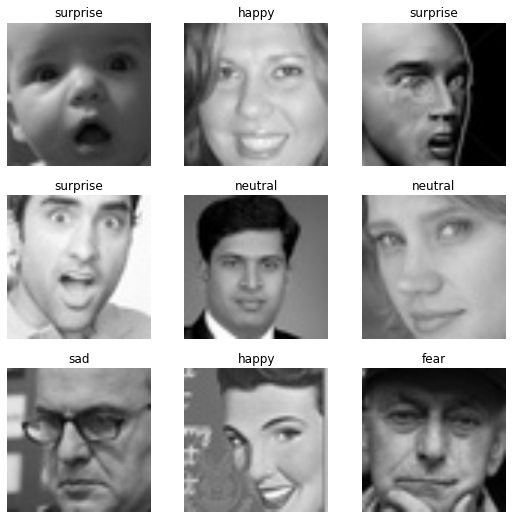

In [6]:
dls.show_batch()

## Import CNN model

In [7]:
# Choose model
arch_model = models.resnet50

In [8]:
# Build TL model based on arch
learning_model = cnn_learner(dls, arch_model, metrics=[accuracy, error_rate])

In [9]:
# learning_model.model

In [10]:
# Labels counter
from collections import Counter
labels_count = Counter(label for label in df['Label'])
labels_count

Counter({'angry': 3995,
         'happy': 7215,
         'disgust': 436,
         'sad': 4830,
         'fear': 4097,
         'neutral': 4965,
         'surprise': 3171})

In [11]:
# Get Class Weights --> This will allow us to compensate the classes with less data
total_count = sum(labels_count.values())
class_weights = {cls: total_count / count for cls, count in labels_count.items()}
class_weights

{'angry': 7.186232790988736,
 'happy': 3.979071379071379,
 'disgust': 65.84633027522936,
 'sad': 5.943892339544513,
 'fear': 7.007322431047108,
 'neutral': 5.782275931520645,
 'surprise': 9.053610848312836}

In [12]:
weights = [*class_weights.values()]
class_weights=torch.FloatTensor(weights).cuda()
learning_model.crit = nn.CrossEntropyLoss(weight=class_weights)

## Training stage 1

SuggestedLRs(lr_min=0.010000000149011612, lr_steep=1.5848931980144698e-06)

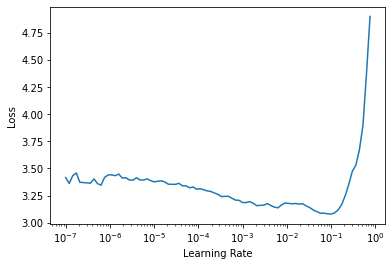

In [13]:
# LR Finder helps to pick a good learning rate
learning_model.lr_find()

In [14]:
# Train
learning_model.fit_one_cycle(4, 1e-02)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.436013,1.455248,0.461244,0.538756,03:54
1,1.204056,1.223470,0.539279,0.460721,03:51
2,1.042493,0.993907,0.621146,0.378854,03:50
3,0.876059,0.949931,0.643094,0.356906,03:51


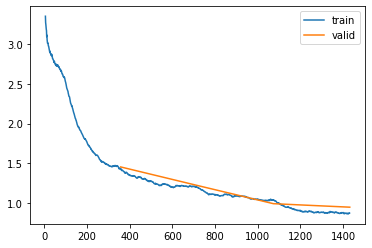

In [15]:
# Plot losses
learning_model.recorder.plot_loss()

In [16]:
# Save stage 1
# model_name = "resnet50_stage1_noNORM_184"
# learning_model.save(root_path / model_name)

## Training stage 2

SuggestedLRs(lr_min=6.309573450380412e-08, lr_steep=3.981071586167673e-06)

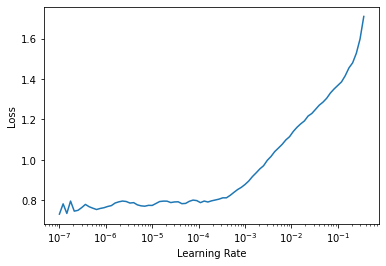

In [17]:
# Unfreeze
learning_model.unfreeze()

# Find LR
learning_model.lr_find()

In [18]:
# Train
learning_model.fit_one_cycle(2, (slice(1e-6, 1e-4)))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.794256,0.940895,0.647448,0.352552,04:51
1,0.708052,0.947963,0.651977,0.348023,04:52


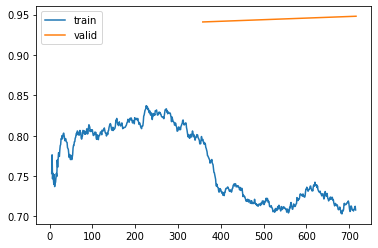

In [19]:
# Plot losses
learning_model.recorder.plot_loss()

In [20]:
# Save stage 2
model_name = "resnet50_stage2_noNORM_184"
learning_model.save(root_path / model_name)

Path('/home/roldanx/code/artificial_intelligence/ownAI/fastai_faces/resnet50_stage2_noNORM_184.pth')

In [ ]:
# Remove ram stored data
del dls
del df

# Testing

In [26]:
# Images Path
path_to_test = Path('/home/roldanx/code/artificial_intelligence/ownAI/fastai_faces/faces/test')

# Generate dataset
filelist = [relpath(os.path.join(dp, f), path_to_test) for dp, dn, filenames in os.walk(path_to_test) for f in filenames]
data_tuples = list(zip(filelist, [x.split("/")[0] for x in filelist]))
df_test = pd.DataFrame(data_tuples, columns=['Path', 'Label'])
df_test

,Path,Label
0,angry/PublicTest_14075653.jpg,angry
1,angry/PrivateTest_73860110.jpg,angry
2,angry/PublicTest_18274972.jpg,angry
3,angry/PublicTest_14798104.jpg,angry
4,angry/PublicTest_51080774.jpg,angry
...,...,...
7173,surprise/PublicTest_17911043.jpg,surprise
7174,surprise/PublicTest_83231837.jpg,surprise
7175,surprise/PrivateTest_95778572.jpg,surprise
7176,surprise/PrivateTest_81533064.jpg,surprise


In [33]:
# Generate test_dataloader
dls_test = ImageDataLoaders.from_df(df_test, path_to_test, valid_pct=0.2, label_col=1, bs=64, item_tfms=Resize(240))

In [37]:
# Switch train_dataloader to test_dataloader 
learning_model.dls = dls_test
arr = learning_model.validate()
arr

# Switch test_dataloader to train_dataloader 
# learning_model.dls = dls
# arr = learning_model.validate()
# arr

(#3) [2.421388864517212,0.20069687068462372,0.7993031144142151]

In [38]:
interp = ClassificationInterpretation.from_learner(test_model)
interp.plot_confusion_matrix(figsize=(8,8), dpi=60)

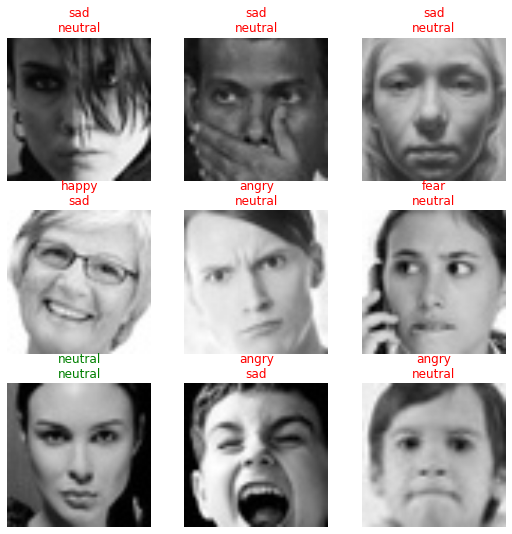

In [29]:
learning_model.show_results()

In [1]:
# learning_model.__dict__